<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 線形方程式の求解

In [22]:
%reset -f

### 直接法  

#### LU分解

LU分解$PA=LU$を求める。
$P$は置換行列$PP^T=I$、$L$は対角成分1の下三角行列、$U$は上三角行列。

LU分解を求める過程には部分ピボット選択付きガウスの消去法から求める外積形式ガウス法や、$PA=LU$から直接成分を比較して求める内積形式ガウス法が存在。ここでは[外積形式ガウス法](https://cedddnav.org/raspi4a/)を使用。
この方法は部分ピボット選択付きガウスの消去法を$L^{-1}PA=U$と比較して$P,L,U$を求める。$P$は最終的な部分ピボット選択全体。$L$は行基本変形の積の逆行列であり、各行基本変形の逆行列が非対角成分の符号を反転させたものであることを利用。

$PA\vec{x}=LU\vec{x}=\vec{b}⇔LU\vec{x}=P^T\vec{b}$であるので
、$L\vec{y}=P^T\vec{b}, U\vec{x}=\vec{y}$として代入操作で解けば、
これは前進・後退代入に対応。

ランダムに生成した正方行列で検証。numpy の LU 分解の機能を使う。
（非正方行列は[疑似逆行列の計算法](https://www.momoyama-usagi.com/entry/math-linear-algebra-ap08)を適用したものとする。）

A=


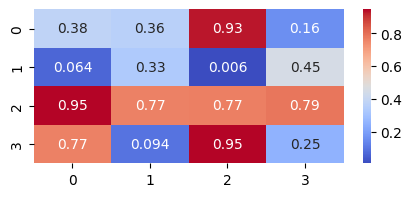

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)

print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

部分ピボット選択付きガウスの消去法で LU 分解を実装

P=


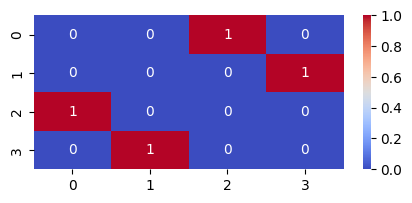

L=


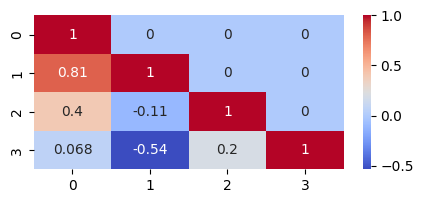

U=


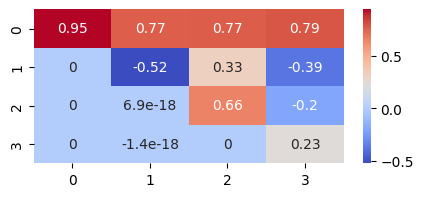

In [24]:
def LU_decomposition(A):
  N = A.shape[0]
  # 置換・行消去は操作なしの単位行列からスタート
  # 前進消去後の行列になる U は A からスタート
  P, L, U = np.eye(N), np.eye(N), A.copy()

  for k in range(N-1):
    # 絶対値の最大要素をピボットとして選択
    # (アンダーフロー・ゼロ除算対策)
    p = np.argmax(abs(U[k:,k])) + k
    if np.isclose(U[p,k], 0):
      raise ValueError("Singular matrix")

    # 行入れ替え
    if p != k:
      P[[k,p],:] = P[[p,k],:]
      U[[k,p],:] = U[[p,k],:]
      if k > 0:
        L[[k,p],:k] = L[[p,k],:k]

    # 前進消去
    for i in range(k+1,N):
      # 基本変形の逆行列 → 符号が逆
      L[i,k] = U[i,k]/U[k,k]
      U[i,:] -= L[i,k]*U[k,:]
  return P, L, U

P, L, U = LU_decomposition(A)

print("P=")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()

print("L=")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()

print("U=")
sns.heatmap(U, annot=True, cmap='coolwarm')
plt.show()

分解が正しいか検算

PA-LU=


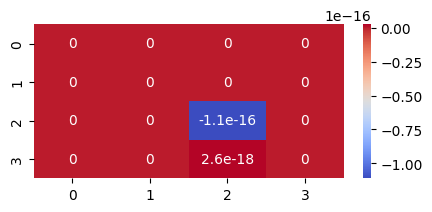

In [25]:
residuals = P @ A - L @ U

print("PA-LU=")
sns.heatmap(residuals, annot=True, cmap='coolwarm')
plt.show()

scipy で検算。置換行列$P$は一致しない場合がある。

δP=


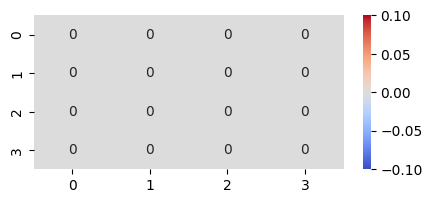

δL=


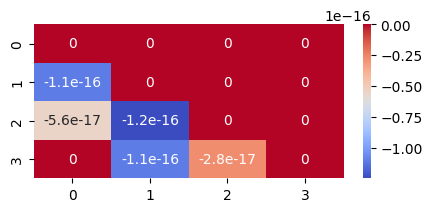

δU=


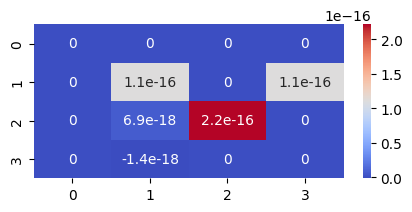

In [26]:
import scipy.linalg as linalg
P2, L2, U2 = linalg.lu(A)

print("δP=")
sns.heatmap(P-P2, annot=True, cmap='coolwarm')
plt.show()

print("δL=")
sns.heatmap(L-L2, annot=True, cmap='coolwarm')
plt.show()

print("δU=")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()

ここから$A\vec{x}=\vec{b}$を解くために$\vec{b}$を生成

In [27]:
b = np.random.rand(N)
print(f"{b=}")

b=array([0.526, 0.929, 0.039, 0.302])


$L\vec{y}=P^T\vec{b}$ を解く。
前進代入は$y_i=b'_i-\sum_{j=0}^{i-1}l_{ij}y_j$。

In [28]:
def forward_substitute(P, L, b):
  N = len(b)
  y = np.zeros(N)
  for i in range(N):
    y[i] = (P.T @ b)[i] - L[i, :i] @ y[:i]
  return y

y = forward_substitute(P, L, b)
print(f"{y=}")

y=array([0.039, 0.271, 0.539, 0.967])


$U\vec{x}=\vec{y}$ を解く。
後退代入は$x_i=(y_i-\sum_{j=i+1}^nu_{ij}x_j)/u_{ii}$。

In [29]:
def backward_substitute(U, y):
  N = len(y)
  x = np.zeros(N)
  for i in range(N-1, -1, -1):
    x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
  return x

x = backward_substitute(U, y)
print(f"{x=}")

x=array([-3.354, -2.335,  2.12 ,  4.269])


解の検算を実施

In [30]:
print(f"{A@x-b=}")

A@x-b=array([-4.441e-16,  0.000e+00, -1.110e-16,  2.220e-16])


逆行列もLU分解から求まる。$AA^{-1}=I$なので$A\vec{x}_i=\vec{e}_i$を解けばいい。これは他の手法でも同じ。

A_inv=


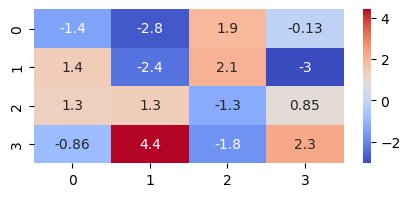

AA_inv=


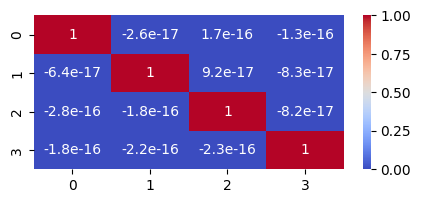

In [31]:
A_inv = np.zeros((N, N))
for i in range(N):
  e_i = np.zeros(N)
  e_i[i] = 1
  y_i = forward_substitute(P, L, e_i)
  x_i = backward_substitute(U, y_i)
  A_inv[:, i] = x_i

print("A_inv=")
sns.heatmap(A_inv, annot=True, cmap='coolwarm')
plt.show()

# 検算
print("AA_inv=")
sns.heatmap(A @ A_inv, annot=True, cmap='coolwarm')
plt.show()

#### コレスキー分解法

解くべき連立一次方程式$A\vec{x}=\vec{b}$の係数行列$A$が非負定値対称行列ならコレスキー分解$A=LL^T$が可能なので、これを利用。
公式は成分比較で求める。

対称性は$A$と比較して$L$の成分が半分であることから必要。
非不定値は平方根の計算のために必要。

不定値なら$(A^TA)\vec{x}=A^T\vec{b}$を解く。$A^TA$は必ず対称で非負定値(特異値分解の部分を参照)。

コレスキー分解は対称正定値行列$A$に対して舌三角行列$L$で$A=LL^T$と分解して、前進・後退代入で$A\vec{x}=\vec{b}$を解く。
あるいは$(AA^T)\vec{x}=(LL^T)\vec{x}=A^T\vec{b}$とする。

L=


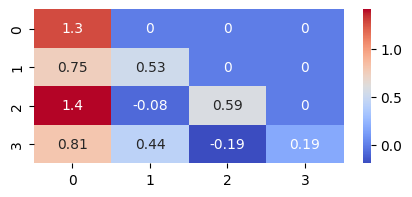

LL^T-A^TA=


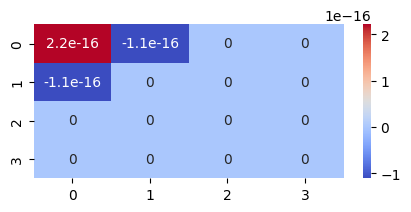

In [32]:
def cholesky_decomposition(A):
  L = np.zeros_like(A)
  N = A.shape[0]
  for i in range(N):
    for j in range(i+1):
      if i == j:
        L[i, j] = np.sqrt(A[i, i] - np.sum(L[i, :j]**2))
      else:
        L[i, j] = (A[i, j] - np.sum(L[i, :j] * L[j, :j])) / L[j, j]
  return L

L = cholesky_decomposition(A.T @ A)

print("L=")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()

print("LL^T-A^TA=")
sns.heatmap(L @ L.T - A.T @ A, annot=True, cmap='coolwarm')
plt.show()

線形方程式$A\vec{x}=\vec{b}$の解法はLU分解と同様

In [33]:
def forward_substitute(L, b):
  N = len(b)
  y = np.zeros(N)
  for i in range(N):
    y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]
  return y


def backward_substitute(LT, y):
  N = len(y)
  x = np.zeros(N)
  for i in range(N-1, -1, -1):
    x[i] = (y[i] - LT[i, i+1:] @ x[i+1:]) / LT[i, i]
  return x


y = forward_substitute(L, A.T @ b)
x = backward_substitute(L.T, y)
print(f"{A@x-b=}")

A@x-b=array([-6.661e-16,  1.998e-15, -9.992e-16,  9.992e-16])


#### 修正コレスキー分解

平方根の計算を避ける修正コレスキー分解ではスケール行列$D'$を抜き出して$A=LL^T≡(L'D')(L'D')^T=L'D'D'^TL'^T\equiv L'DL'^T$とする。
$L'$の対角成分はすべて1である。

成分比較から分解の公式を求める。

L=


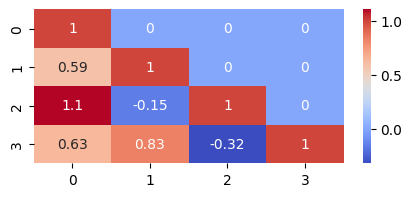

D=


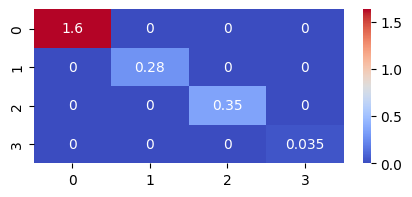

L D L^T - A^T A=


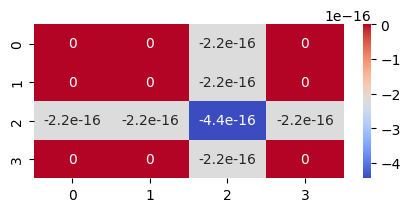

In [34]:
def modified_cholesky_decomposition(A):
  L, D = np.zeros_like(A), np.zeros_like(A)

  N = A.shape[0]
  for i in range(N):
    for j in range(i+1):
      if i == j:
        L[i, i] = 1
        D[i, i] = A[i, i] - np.sum(L[i, :i]**2 * D[:i, :i])
      else:
        L[i, j] = (A[i, j] - np.sum(L[i, :j] * L[j, :j] * D[:j, :j])) / D[j, j]
  return L, D

L, D = modified_cholesky_decomposition(A.T @ A)

print("L=")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()

print("D=")
sns.heatmap(D, annot=True, cmap='coolwarm')
plt.show()

print("L D L^T - A^T A=")
sns.heatmap(L @ D @ L.T - A.T @ A, annot=True, cmap='coolwarm')
plt.show()

線形方程式$A\vec{x}=\vec{b}$の解法はコレスキー分解と同様

In [35]:
def forward_substitute(L, b):
  N = len(b)
  y = np.zeros(N)
  for i in range(N):
    y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]
  return y


def backward_substitute(LT, y):
  N = len(y)
  x = np.zeros(N)
  for i in range(N-1, -1, -1):
    x[i] = (y[i] - LT[i, i+1:] @ x[i+1:]) / LT[i, i]
  return x


y = forward_substitute(L @ D, A.T @ b)
x = backward_substitute(L.T, y)
print(f"{A@x-b=}")

A@x-b=array([ 1.554e-15,  4.219e-15, -9.992e-16,  6.661e-16])


### 間接法

間接法は反復更新で解に収束させることで解く。
[大きく定常法と非定常法に分けられる](http://nkl.cc.u-tokyo.ac.jp/13n/SolverIterative.pdf)。

#### 定常法

対象の行列$A$を下三角$L$・対角$D$・上三角$U$に分解。つまり$A=D+L+U$。

L=


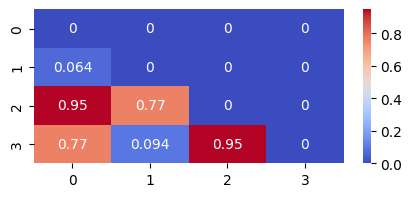

D=


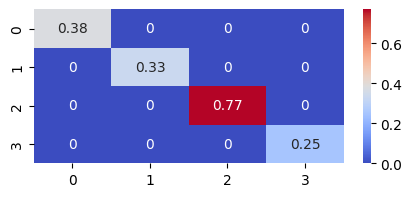

U=


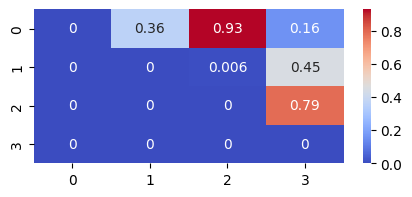

In [36]:
L = np.tril(A, -1)
D = np.diag(np.diag(A))
U = np.triu(A, 1)

print("L=")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()

print("D=")
sns.heatmap(D, annot=True, cmap='coolwarm')
plt.show()

print("U=")
sns.heatmap(U, annot=True, cmap='coolwarm')
plt.show()

##### ヤコビ法

反復の漸化式は
\begin{equation}
\vec{x}^{(k+1)}=D^{-1}(\vec{b}-(L+U)\vec{x}^{(k)})
\end{equation}

In [37]:
def jacobi_step(L, D, U, x, b):
  Dinv = np.diag(1/np.diag(D))
  return Dinv @ (b - (L + U) @ x)

この反復で$A\vec{x}=\vec{b}$を満たす$\vec{x}$を求める。
収束のための十分条件は狭義行・列対角優位性なので、ランダム生成した行列$A$では収束しない可能性があることに気を付ける。

In [41]:
max_step = 100
eps = 1e-6

x = np.ones(A.shape[0])
for step in range(max_step):
  print(x)
  x_new = jacobi_step(L, D, U, x, b)
  if np.linalg.norm(x_new - x) < eps:
    break
  x = x_new

print(f"{x=}")
print(f"{A@x-b=}")

[1. 1. 1. 1.]
[-2.438  1.233 -3.198 -5.961]
[10.53  11.312  7.929 20.142]
[-37.209 -26.414 -44.776 -64.707]
[163.405  97.585 138.342 291.977]
[ -552.288  -422.973  -596.97  -1050.002]
[2306.078 1528.86  2175.203 4074.666]
[ -8486.783  -5948.173  -8529.231 -15727.241]
[33137.159 22894.702 32458.815 59972.468]
[-126396.458  -87438.65  -124938.102 -230867.456]
[485878.234 336388.622 478830.455 884894.781]
[-1863395.989 -1289605.758 -1838286.886 -3396285.856]
[ 7151674.634  4949339.524  7052234.602 13032164.346]
[-27439163.157 -18991756.855 -27063412.599 -50005577.819]
[1.053e+08 7.287e+07 1.038e+08 1.919e+08]
[-4.040e+08 -2.796e+08 -3.985e+08 -7.363e+08]
[1.550e+09 1.073e+09 1.529e+09 2.825e+09]
[-5.949e+09 -4.117e+09 -5.867e+09 -1.084e+10]
[2.283e+10 1.580e+10 2.251e+10 4.160e+10]
[-8.759e+10 -6.062e+10 -8.638e+10 -1.596e+11]
[3.361e+11 2.326e+11 3.315e+11 6.125e+11]
[-1.290e+12 -8.926e+11 -1.272e+12 -2.350e+12]
[4.949e+12 3.425e+12 4.881e+12 9.018e+12]
[-1.899e+13 -1.314e+13 -1.873e+13 

#### 非定常法

共役勾配法は2次形式の最適化問題に変形して適用。

## 特異値分解

In [ ]:
%reset -f

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

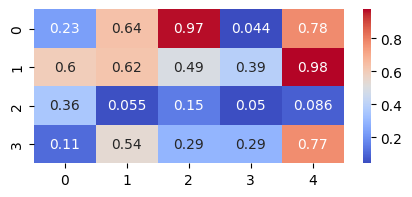

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

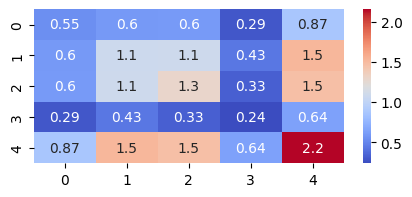

In [ ]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([4.853e+00, 2.899e-01, 1.668e-01, 3.691e-04, 7.052e-17])


<Axes: >

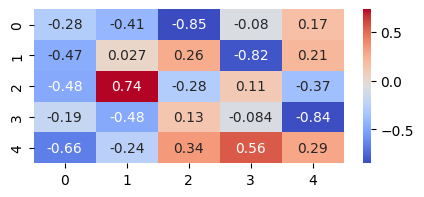

In [ ]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

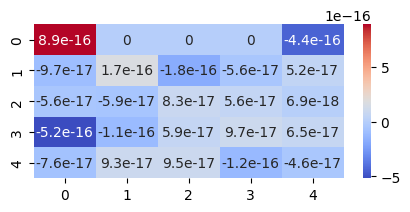

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

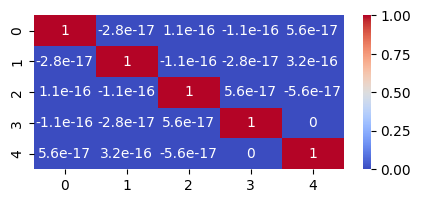

In [ ]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([4.853e+00, 2.899e-01, 1.668e-01, 3.691e-04])


<Axes: >

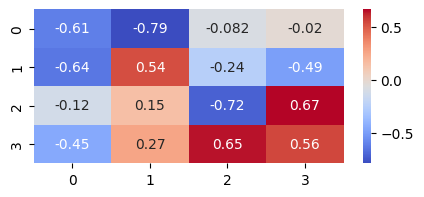

In [ ]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

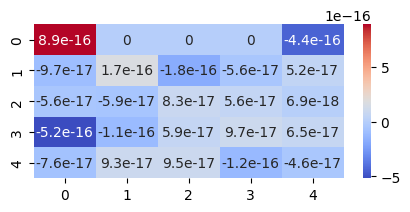

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

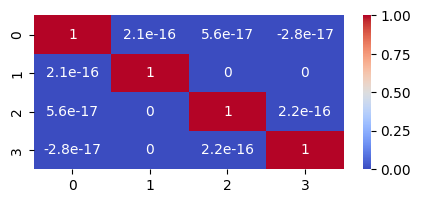

In [ ]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [ ]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([4.853e+00, 2.899e-01, 1.668e-01, 3.691e-04, 0.000e+00])
w_left=array([4.853e+00, 2.899e-01, 1.668e-01, 3.691e-04])


$A^TA, AA^T$ の固有値の平方根は特異値

In [ ]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.203, 0.538, 0.408, 0.019, 0.   ])
sigma_left=array([2.203, 0.538, 0.408, 0.019])


特異値による行列 $\Sigma$ を作成

In [ ]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.203, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.538, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.408, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.019, 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

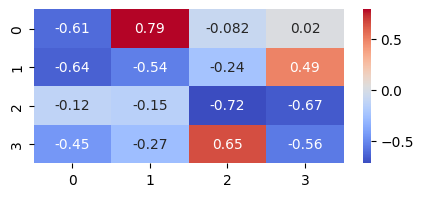

In [ ]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

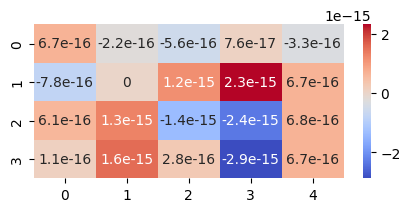

In [ ]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [ ]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.203 0.538 0.408 0.019]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([ 8.882e-16,  1.110e-16, -5.551e-17,  9.576e-16])


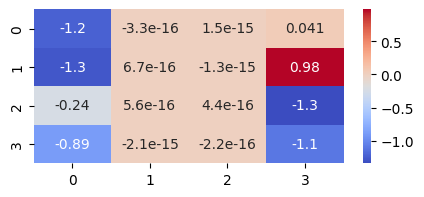

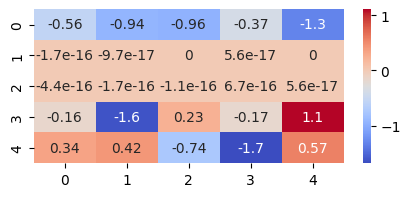

In [ ]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

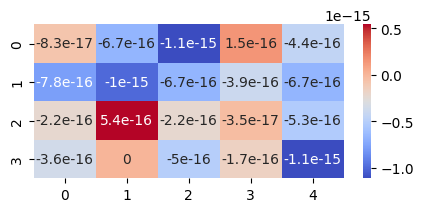

In [ ]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。